<a href="https://colab.research.google.com/github/Shyam-G-Sundhar/Sentimental-Analysis-using-Naive-Bayes-Movie-/blob/main/Copy_of_Sentimental_Analysis_using_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'imdb-dataset-of-50k-movie-reviews:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F134715%2F320111%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240808%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240808T042610Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D04dd683f8ea4e2ae9d043c76c67e8a205ecd0ca612c803bbe2356ce0c20ed61d4cade8ca93157fa54f161a427ead85ddfd0d87227e9a35074e798c802eab35e77c867f6c21cf694f2c2dd37b09827d9bf5046bceffff2d078b9655219bb34068d1f78c7609b49768f131ef45a0d4ab11b54f1598a15d92806b77dc668446ef6b5d88a1d0423425cb5ada0e642e06d2f7b0d3f8654fa6c867ab4247e0733154d4b68a8aa2897199068fb0df9c43f97a2b02ae110caff359b67d8d23fb970d4e4941ddbf45a33577abea79a817996c91d0d87b7d67366fb71dc11470f3186918734daf868d7821844f971541b3f2235a7905ede41650cedcbfbaa2c12c8e142f4d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 26962657 bytes downloaded
Downloaded and uncompressed: imdb-dataset-of-50k-movie-reviews
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df=pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [5]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
df.shape

(50000, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [8]:
df.describe().T

,count,unique,top,freq
review,50000,49582,Loved today's show!!! It was a variety and not...,5
sentiment,50000,2,positive,25000


In [9]:
df.isnull().sum()

,0
review,0
sentiment,0


In [10]:
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


<Axes: xlabel='sentiment', ylabel='count'>

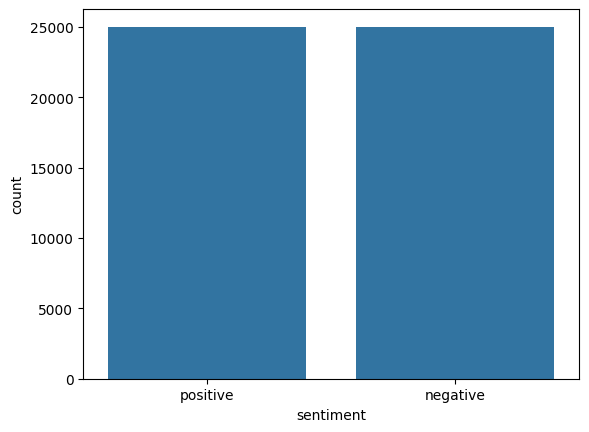

In [11]:
sns.countplot(x='sentiment',data=df)

<Axes: >

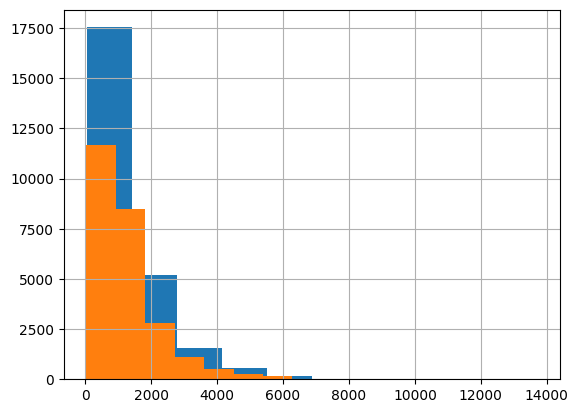

In [12]:
df[df['sentiment']=='positive']['review'].str.len().hist()
df[df['sentiment']=='negative']['review'].str.len().hist()

In [13]:
from wordcloud import WordCloud

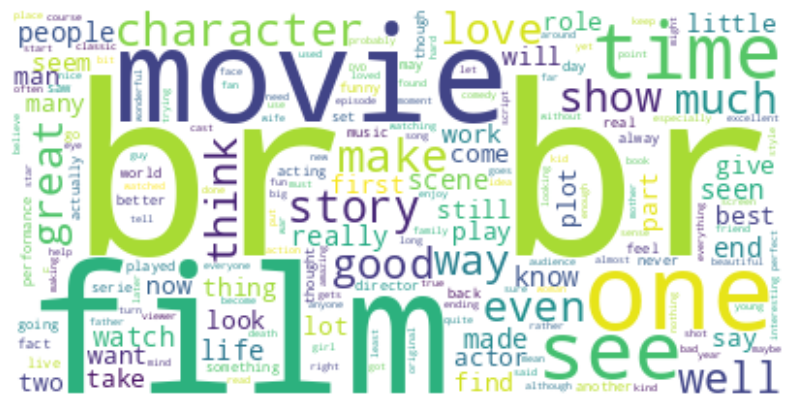

In [14]:
postitive_txt=' '.join(df[df['sentiment']=='positive']['review'])
wordcloud=WordCloud(background_color='white').generate(postitive_txt)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

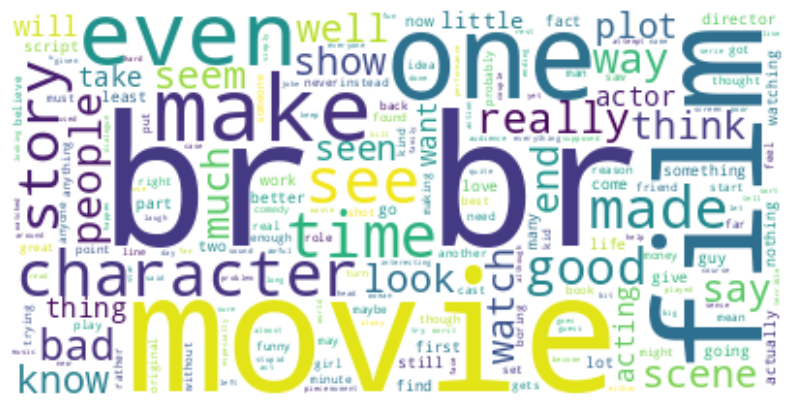

In [15]:
negative_txt=' '.join(df[df['sentiment']=='negative']['review'])
wordcloud=WordCloud(background_color='white').generate(negative_txt)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [16]:
df['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [17]:
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
def clean(text):
  text=text.lower()
  text=re.sub('\[.*?\]','',text)
  text=re.sub('[%s]'%re.escape(string.punctuation),'',text)
  text=re.sub('\w*\d\w*','',text)
  text=re.sub('[''""_]','',text)
  text=re.sub('\n','',text)
  text=re.sub('br','',text)
  text=re.sub('\s+',' ',text)
  text=re.sub(r'http\S+', '', text)
  text=re.sub("isn't",'is not',text)
  text=re.sub("he's",'he is',text)
  text=re.sub("wasn't",'was not',text)
  text=re.sub("there's",'there is',text)
  text=re.sub("couldn't",'could not',text)
  text=re.sub("won't",'will not',text)
  text=re.sub("they're",'they are',text)
  text=re.sub("she's",'she is',text)
  text=re.sub("There's",'there is',text)
  text=re.sub("wouldn't",'would not',text)
  text=re.sub("haven't",'have not',text)
  text=re.sub("That's",'That is',text)
  text=re.sub("you've",'you have',text)
  text=re.sub("He's",'He is',text)
  text=re.sub("what's",'what is',text)
  text=re.sub("weren't",'were not',text)
  text=re.sub("we're",'we are',text)
  text=re.sub("hasn't",'has not',text)
  text=re.sub("you'd",'you would',text)
  text=re.sub("shouldn't",'should not',text)
  text=re.sub("let's",'let us',text)
  text=re.sub("they've",'they have',text)
  text=re.sub("You'll",'You will',text)
  text=re.sub("i'm",'i am',text)
  text=re.sub("we've",'we have',text)
  text=re.sub("it's",'it is',text)
  text=re.sub("don't",'do not',text)
  text=re.sub("that´s",'that is',text)
  text=re.sub("I´m",'I am',text)
  text=re.sub("it’s",'it is',text)
  text=re.sub("she´s",'she is',text)
  text=re.sub("he’s'",'he is',text)
  text=re.sub('I’m','I am',text)
  text=re.sub('I’d','I did',text)
  text=re.sub("he’s'",'he is',text)
  text=re.sub('there’s','there is',text)
  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [18]:
 df['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [19]:
df['review']=df['review'].apply(clean)

In [20]:
df['review'][0]

'one of the other reviewers has mentioned that after watching just oz episode youll be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its utality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare forget pretty picture

In [21]:
stop = set(stopwords.words('english'))
print(stop)

{'same', 'couldn', 'its', 'they', 'shan', 'me', 'my', 'where', 'so', 'to', 'during', 'had', "you'll", 'do', 'hers', 'by', 'were', 'any', 'myself', 'which', 'now', 'm', 'ours', 'doesn', 'with', 'then', 'yourself', 'how', 'most', 'i', 'being', 'there', 'above', "wasn't", 'who', 'am', 'further', 'have', "haven't", 'himself', 'some', "it's", 've', 'our', 'your', 'won', 'ourselves', 'off', 'over', 'yourselves', 'should', 'each', 'while', 'o', "couldn't", "needn't", 'been', 'yours', 'from', 'once', 'these', 'up', 'until', "shan't", 'at', 'no', 'why', 'we', 'he', 'theirs', 'more', 'does', 'y', 'nor', 'a', 'here', 't', 'an', 'can', 'be', "should've", 'll', 'those', 'own', "mightn't", 'as', 'out', 'into', 'if', 'is', 'ma', 'don', 'her', 'd', 'mightn', 'whom', 'about', 'both', 'wouldn', 'she', 'this', 'not', 'below', 'ain', 'was', "doesn't", 'such', 're', 'because', "that'll", "wouldn't", "don't", 'will', 'their', 'very', 'having', "hasn't", 'itself', 'you', 'hadn', 'but', "aren't", 'after', 'ag

In [22]:
df['review']=df['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [23]:
df['review'][0]

'one reviewers mentioned watching oz episode youll hooked right exactly happened first thing struck oz utality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered middle class inmates

In [24]:
df['sentiment']=df['sentiment'].apply(lambda x: 1 if x=='positive' else 0)
df['sentiment']

,sentiment
0,1
1,1
2,1
3,0
4,1
...,...
49995,1
49996,0
49997,0
49998,0


In [25]:
df.head()

,review,sentiment
0,one reviewers mentioned watching oz episode yo...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically theres family little boy jake thinks...,0
4,petter matteis love time money visually stunni...,1


In [26]:
from collections import Counter
cn=Counter()
for text in df['review'].values:
  for word in text.split():
    cn[word]+=1
cn.most_common(10)
newdf=pd.DataFrame(cn.most_common(10),columns=['word','count'])
newdf

,word,count
0,movie,85217
1,film,76026
2,one,51472
3,like,39061
4,good,28912
5,even,24580
6,would,24034
7,time,23964
8,really,23011
9,see,22639


<ipython-input-27-f136a8d89803>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count',y='word',data=newdf,palette='deep',orient='h')


<Axes: xlabel='count', ylabel='word'>

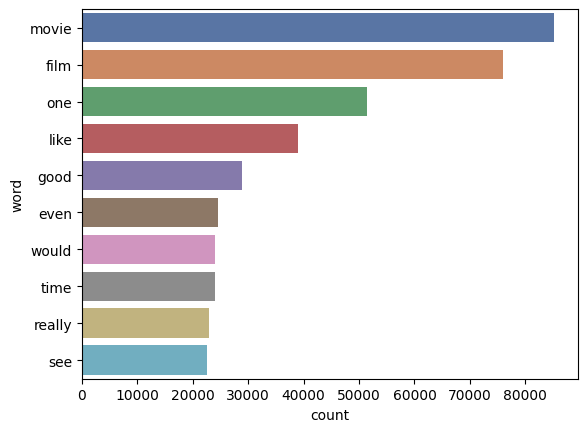

In [27]:
sns.barplot(x='count',y='word',data=newdf,palette='deep',orient='h')

In [33]:
freqwords=set([w for (w, wc) in cn.most_common(10)])
freqwords

{'also',
 'bad',
 'dont',
 'first',
 'get',
 'great',
 'much',
 'people',
 'story',
 'well'}

In [32]:
def remfreq(text):
  return ' '.join([word for word in str(text).split() if word not in freqwords])
df['review']=df['review'].apply(lambda text: remfreq(text))

In [35]:
df['review'][5]

'probably alltime favorite selflessness sacrifice dedication noble cause preachy boring never gets old despite seen times last years paul lukas performance ings tears eyes bette davis truly sympathetic roles delight kids grandma says dressedup midgets children makes fun watch mothers slow awakening whats happening world roof believable startling dozen thumbs theyd'

In [36]:
wordnet=WordNetLemmatizer()
def lemmatize(text):
  return ' '.join([wordnet.lemmatize(word) for word in text.split()])
df['review']=df['review'].apply(lambda text: lemmatize(text))

In [37]:
df['review'][5]

'probably alltime favorite selflessness sacrifice dedication noble cause preachy boring never get old despite seen time last year paul lukas performance ings tear eye bette davis truly sympathetic role delight kid grandma say dressedup midget child make fun watch mother slow awakening whats happening world roof believable startling dozen thumb theyd'

In [40]:
df['review']=df['review'].apply(lambda x: x.split())
df

,review,sentiment
0,"[reviewer, mentioned, watching, oz, episode, y...",1
1,"[wonderful, little, production, filming, techn...",1
2,"[thought, wonderful, way, spend, hot, summer, ...",1
3,"[basically, there, family, little, boy, jake, ...",0
4,"[petter, matteis, love, money, visually, stunn...",1
...,...,...
49995,"[thought, right, job, wasnt, creative, origina...",1
49996,"[plot, dialogue, acting, idiotic, directing, a...",0
49997,"[catholic, taught, parochial, elementary, scho...",0
49998,"[im, going, disagree, previous, comment, side,...",0


In [41]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
token=RegexpTokenizer(r'[a-zA-Z0-9]+')
cv=CountVectorizer(stop_words='english',ngram_range=(1,1),tokenizer=token.tokenize)
X=cv.fit_transform(df['review'].apply(lambda x: ' '.join(x)))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [45]:
from sklearn.model_selection import train_test_split
y=df['sentiment']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

In [52]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.naive_bayes import MultinomialNB,BernoulliNB,ComplementNB
mmdl=MultinomialNB()
mmdl.fit(X_train,y_train)
mmdl.score(X_test,y_test)
mmdl.predict(X_test)
mmdl_acc=accuracy_score(mmdl.predict(X_test),y_test)
print(mmdl_acc)
print('\n')
print(classification_report(mmdl.predict(X_test),y_test))
print('\n')
print(confusion_matrix(mmdl.predict(X_test),y_test))

0.8583


              precision    recall  f1-score   support

           0       0.88      0.85      0.86      5227
           1       0.84      0.87      0.85      4773

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



[[4427  800]
 [ 617 4156]]


In [53]:
bmdl=BernoulliNB()
bmdl.fit(X_train,y_train)
bmdl.score(X_test,y_test)
bmdl.predict(X_test)
bmdl_acc=accuracy_score(bmdl.predict(X_test),y_test)
print(bmdl_acc)
print('\n')
print(classification_report(bmdl.predict(X_test),y_test))
print('\n')
print(confusion_matrix(bmdl.predict(X_test),y_test))

0.852


              precision    recall  f1-score   support

           0       0.88      0.83      0.86      5362
           1       0.82      0.87      0.85      4638

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



[[4463  899]
 [ 581 4057]]


In [54]:
cmdl=ComplementNB()
cmdl.fit(X_train,y_train)
cmdl.score(X_test,y_test)
cmdl.predict(X_test)
cmdl_acc=accuracy_score(cmdl.predict(X_test),y_test)
print(cmdl_acc)
print('\n')
print(classification_report(cmdl.predict(X_test),y_test))
print('\n')
print(confusion_matrix(cmdl.predict(X_test),y_test))

0.8583


              precision    recall  f1-score   support

           0       0.88      0.85      0.86      5229
           1       0.84      0.87      0.85      4771

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



[[4428  801]
 [ 616 4155]]


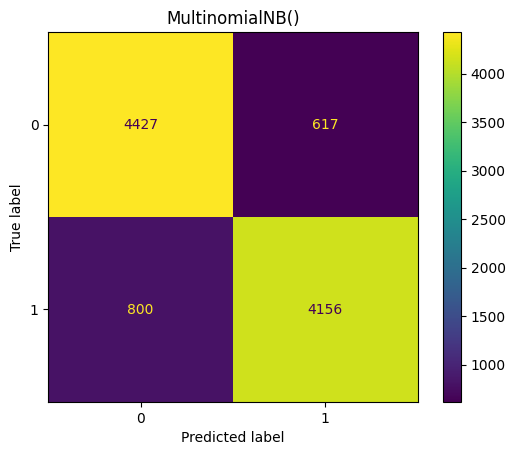

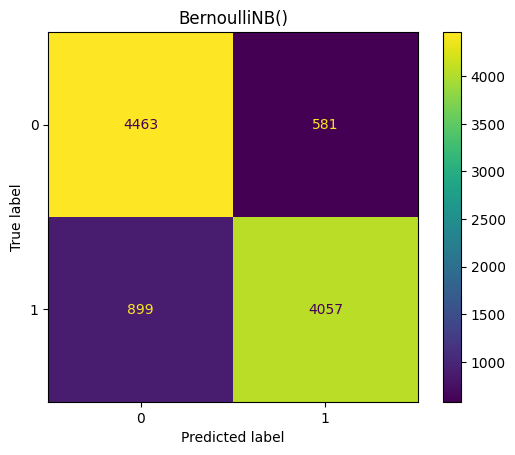

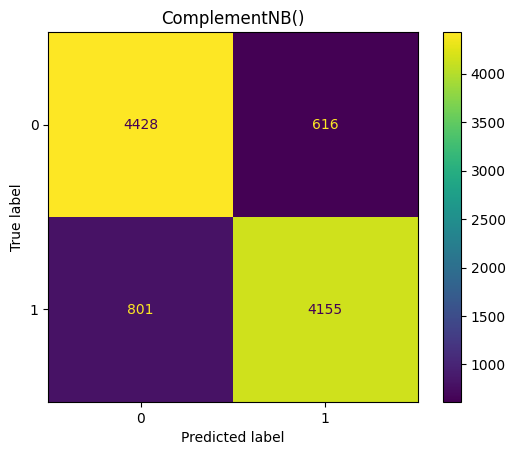

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')
k=[mmdl,bmdl,cmdl]
for i in k:
  ConfusionMatrixDisplay.from_estimator(i,X_test,y_test)
  plt.title(i)
  plt.show()
  print(  )

In [79]:
from sklearn.metrics import roc_curve, roc_auc_score
cprob=cmdl.predict_proba(X_test)
mprob=mmdl.predict_proba(X_test)
bprob=bmdl.predict_proba(X_test)
fpr1,tpr1,thresholds1=roc_curve(y_test,cprob[:,1])
fpr2,tpr2,thresholds2=roc_curve(y_test,mprob[:,1])
fpr3,tpr3,thresholds3=roc_curve(y_test,bprob[:,1])

rprob=[0 for i in range(len(y_test))]
p_fpr,p_tpr,_=roc_curve(y_test,rprob,pos_label=1)

In [80]:
from sklearn.metrics import roc_auc_score

auc1=roc_auc_score(y_test,cprob[:,1])
auc2=roc_auc_score(y_test,mprob[:,1])
auc3=roc_auc_score(y_test,bprob[:,1])
print(auc1,auc2,auc3)

0.9269076397276205 0.9269073997090335 0.928339190586919


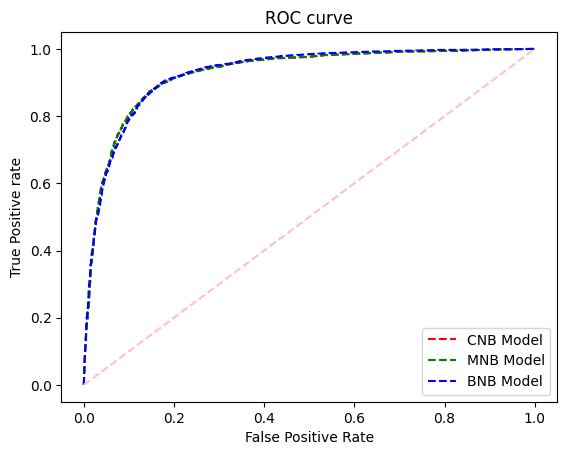

In [85]:
plt.plot(fpr1, tpr1, linestyle='--',color='red', label='CNB Model')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='MNB Model')
plt.plot(fpr3, tpr3, linestyle='--',color='blue', label='BNB Model')
plt.plot(p_fpr, p_tpr, linestyle='--', color='pink')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

In [107]:
res=cmdl.predict(cv.transform(['I loved the Movie']))
if res==1:
  print('Positive Review')
else:
  print('Negative Review')

Positive Review
